In [ ]:
from tqdm import tqdm
import scanpy as sc

In [59]:
sample_folders = [
    "GSM4456251_ALL1",
    "GSM4456252_ALL3",
    "GSM4456253_ALL8",
    "GSM4456254_ALL9",
    "GSM4456255_ALL10",
    "GSM4456256_ALL12",
    "GSM4456257_ALL10-d15",
    "GSM4456258_ALL12-d15",
]
# Create an empty list first
adata_list = []

# use a for-loop to read in all the files
for sample in tqdm(sample_folders):
    pathname = "/Users/Ali/Desktop/Mehtonen et al./GSE148218_RAW/" + sample
    print("Reading files at:" + pathname)
    adata = sc.read_10x_mtx(
        "/Users/Ali/Desktop/Mehtonen et al./GSE148218_RAW/" + sample
    )
    patient_id = sample[:4]  # extract the patient info
    sample_id = sample  # extract the sample info
    # we add the patient and sample information into our adata object, specifically, the .obs slot
    # .obs stands for observation i.e every single-cell is an observation
    adata.obs["patient_id"] = patient_id
    adata.obs["sample_id"] = sample_id
    # the function will complain that we need to run this
    adata.var_names_make_unique()  # a var, stands for variable i.e. genes. so this function is to make the gene names unique
    # why? because multiple ensembl gene ids can map to the same gene e.g. spliced isoforms. sometimes we care about spliced isoforms and we want to keep them separate
    # so something like IL6, would be become IL6 and IL6-1
    adata_list.append(adata)  # append to my adata_list above, iteratively

# finally, concatenate all the objects into a singlular one
adata = sc.concat(adata_list)
# print what the final object looks like
adata

In [ ]:
adata.write_h5ad("/Users/Ali/Desktop/Mehtonen et al./GSE148218_RAW/adata_rb.h5ad", compression="gzip")

In [117]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

adata = sc.read_h5ad("/Users/Ali/Desktop/Mehtonen et al./GSE148218_RAW/adata_rb.h5ad")
adata

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.5 pynndescent==0.5.10


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 50747 × 32738
    obs: 'patient_id', 'sample_id'

In [118]:
import os
os.makedirs('write', exist_ok=True)
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results
adata.write(results_file)
#adata = sc.read_10x_mtx('/Users/Ali/Desktop/Mehtonen et al./GSE148218_RAW/ALL1',
    #var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    #cache=True)                             # write a cache file for faster subsequent reading


#adata = sc.read_10x_mtx(
    #'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    #var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    #cache=True)                              # write a cache file for faster subsequent reading

#adata.var_names_make_unique()
print(results_file)

write/pbmc3k.h5ad


normalizing counts per cell


    finished (0:00:00)


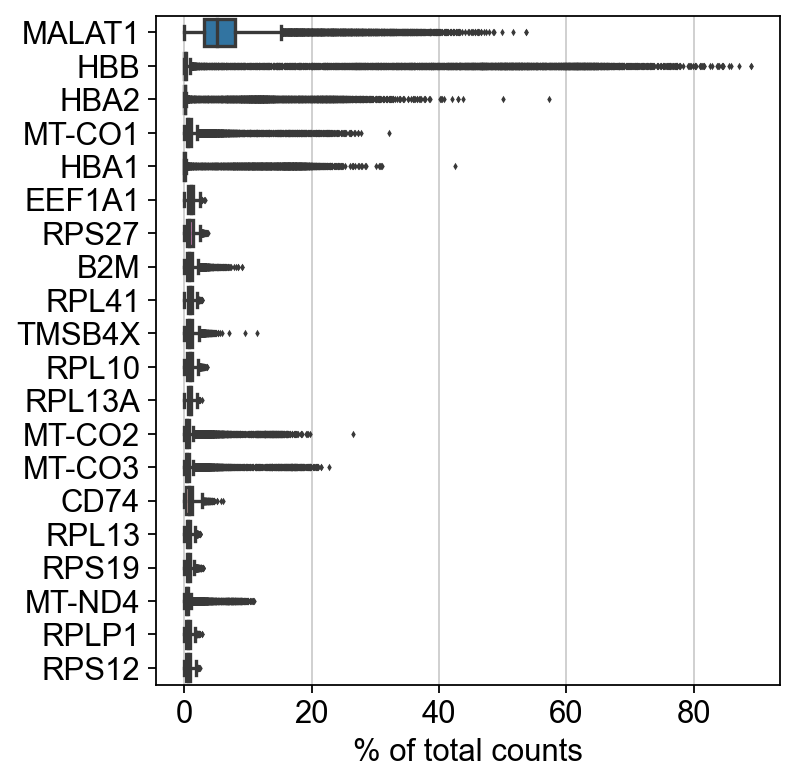

In [119]:
sc.pl.highest_expr_genes(adata, n_top=20, )
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.

In [120]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1270 cells that have less than 200 genes expressed


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 11255 genes that are detected in less than 3 cells


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [121]:
#Mitochondrial genes for quality control.

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix
the total counts per cell
the percentage of counts in mitochondrial genes

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


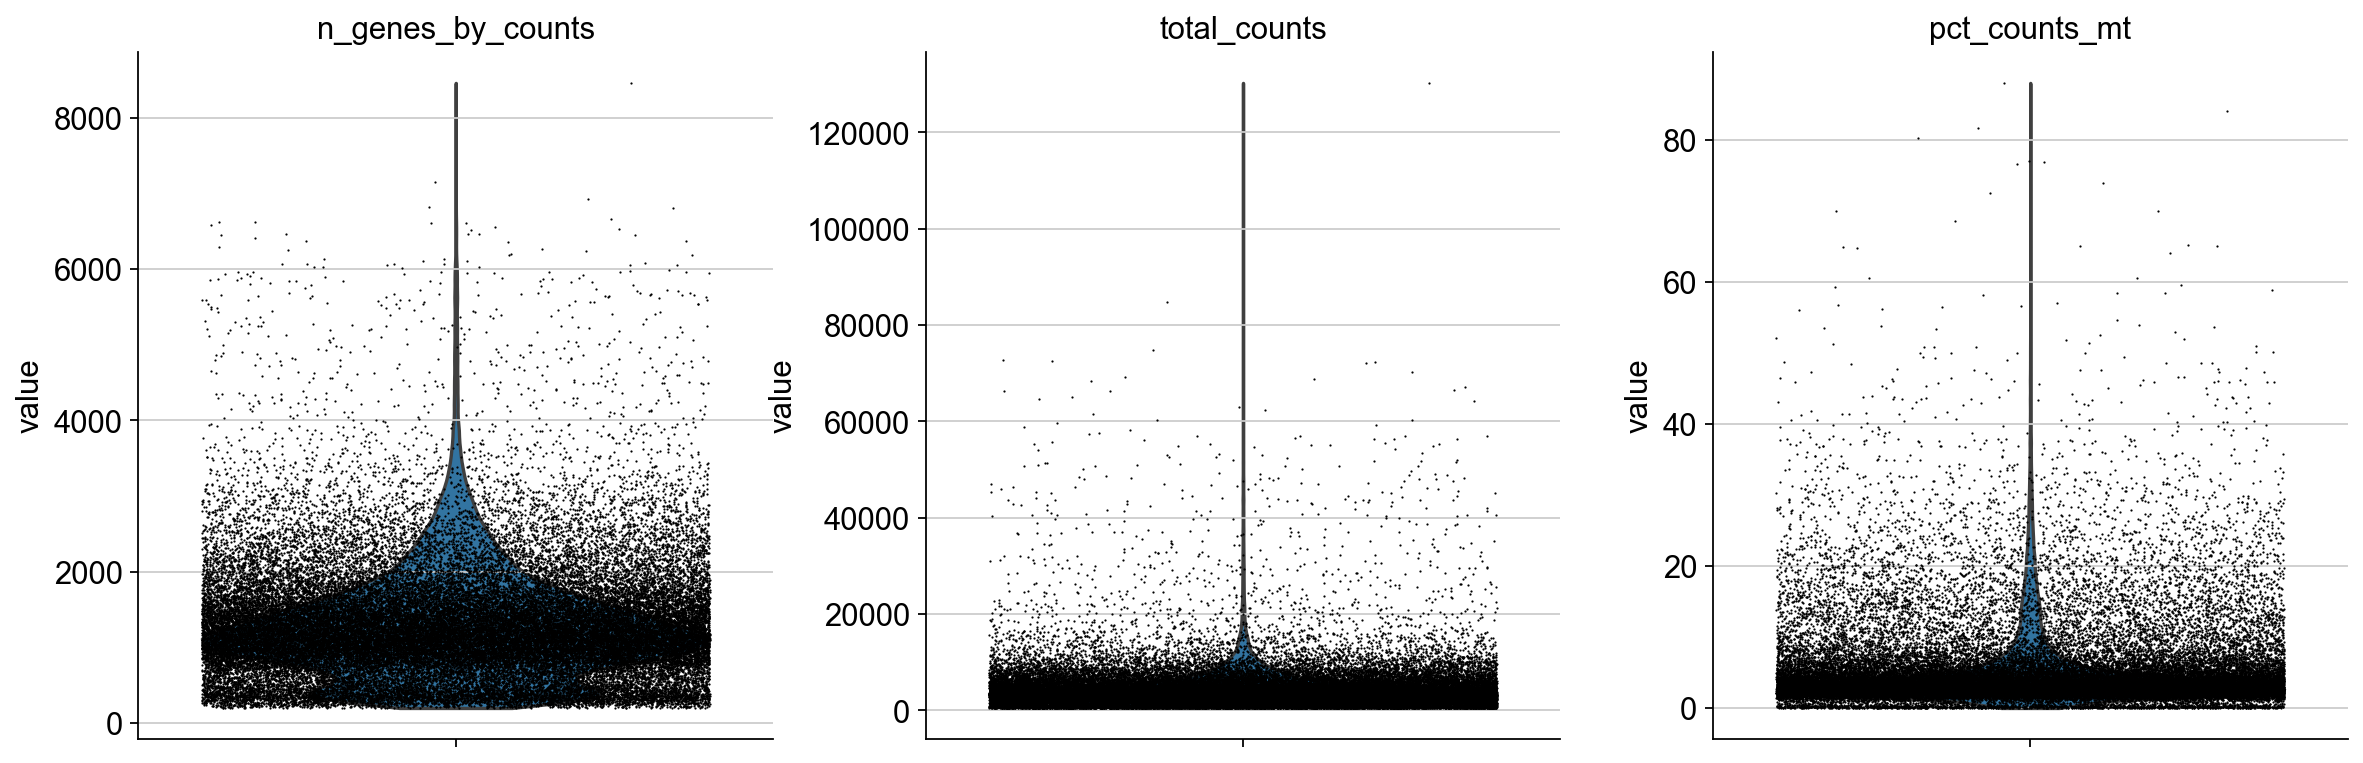

In [122]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


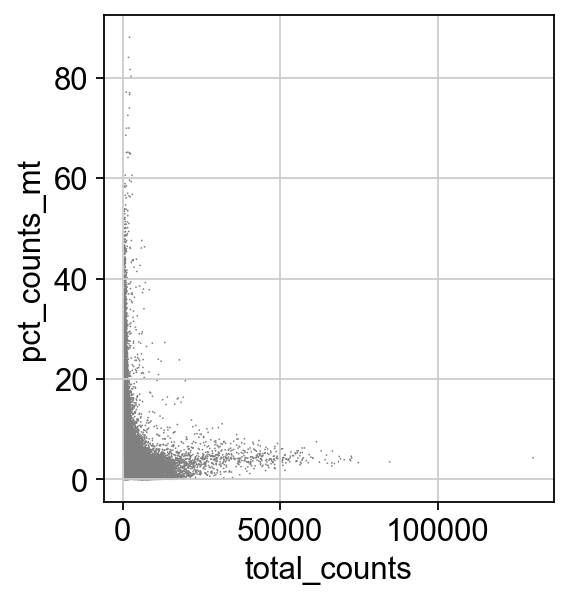

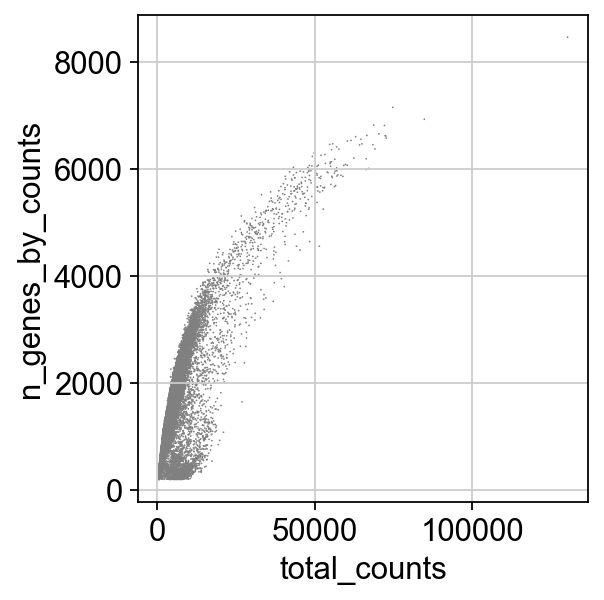

In [123]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [124]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [125]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


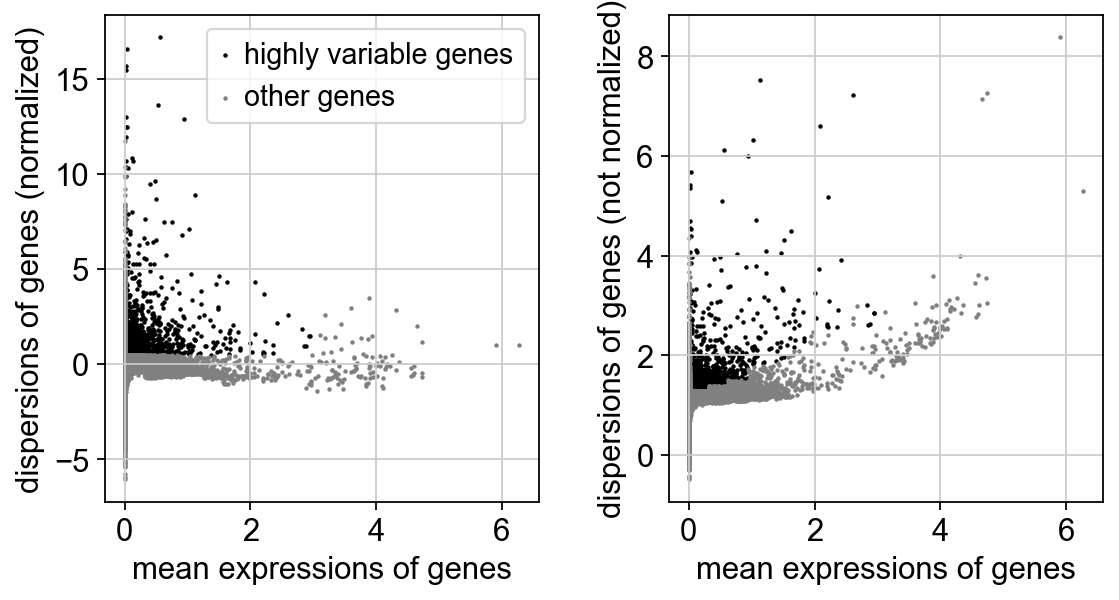

In [126]:
sc.pl.highly_variable_genes(adata)


In [127]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]


In [128]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:29)


In [129]:
#Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


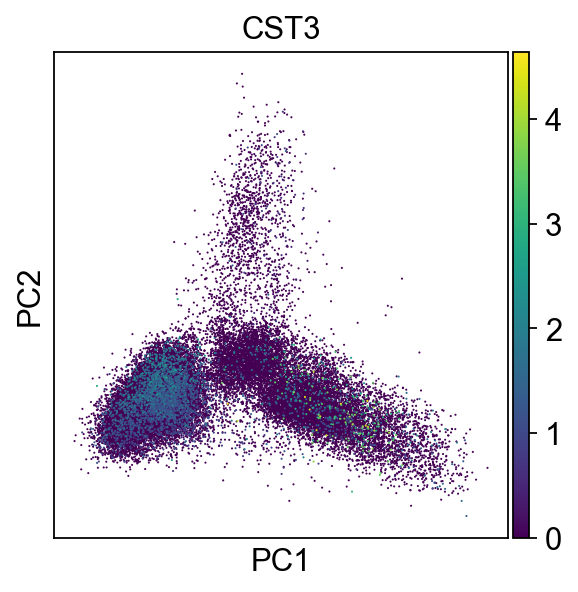

In [130]:
sc.pl.pca(adata, color='CST3')

In [131]:
adata.write(results_file)

What are the Single PCs to the total variance in the data. 

This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

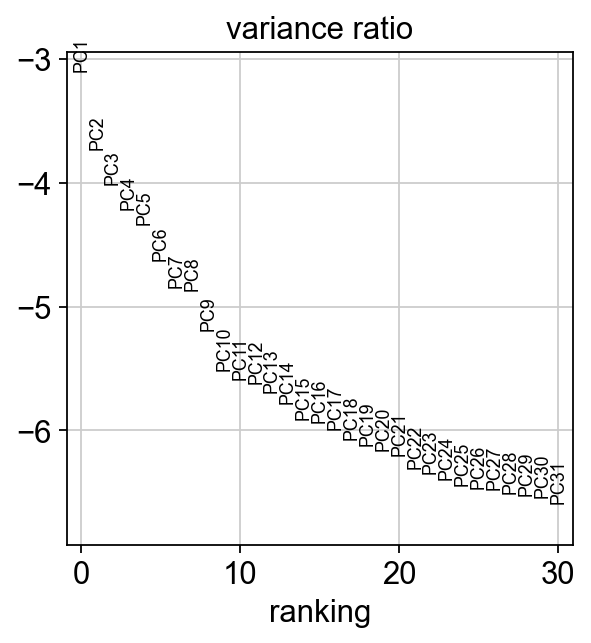

In [132]:
sc.pl.pca_variance_ratio(adata, log=True)

In [133]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 33802 × 1423
    obs: 'patient_id', 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [134]:
#Computing the neighborhood graph
#compute the neighborhood graph of cells using the PCA representation of the data matrix.

sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [135]:
#Embedding the neighborhood graph
#embedding the graph in two dimensions using UMAP -> potentially more faithful to the global connectivity of the manifold than tSNE, 
#i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations

sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:20)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


In [136]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


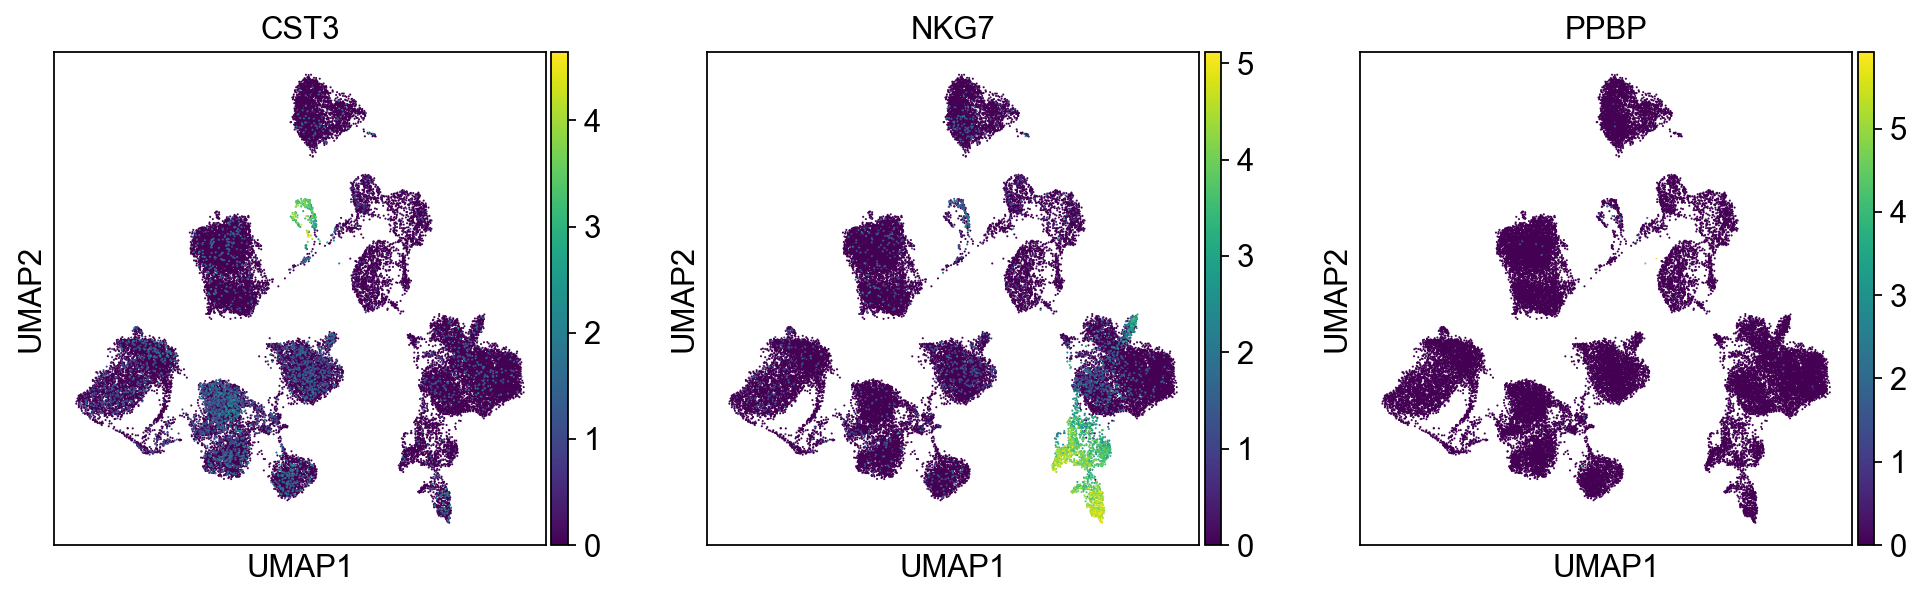

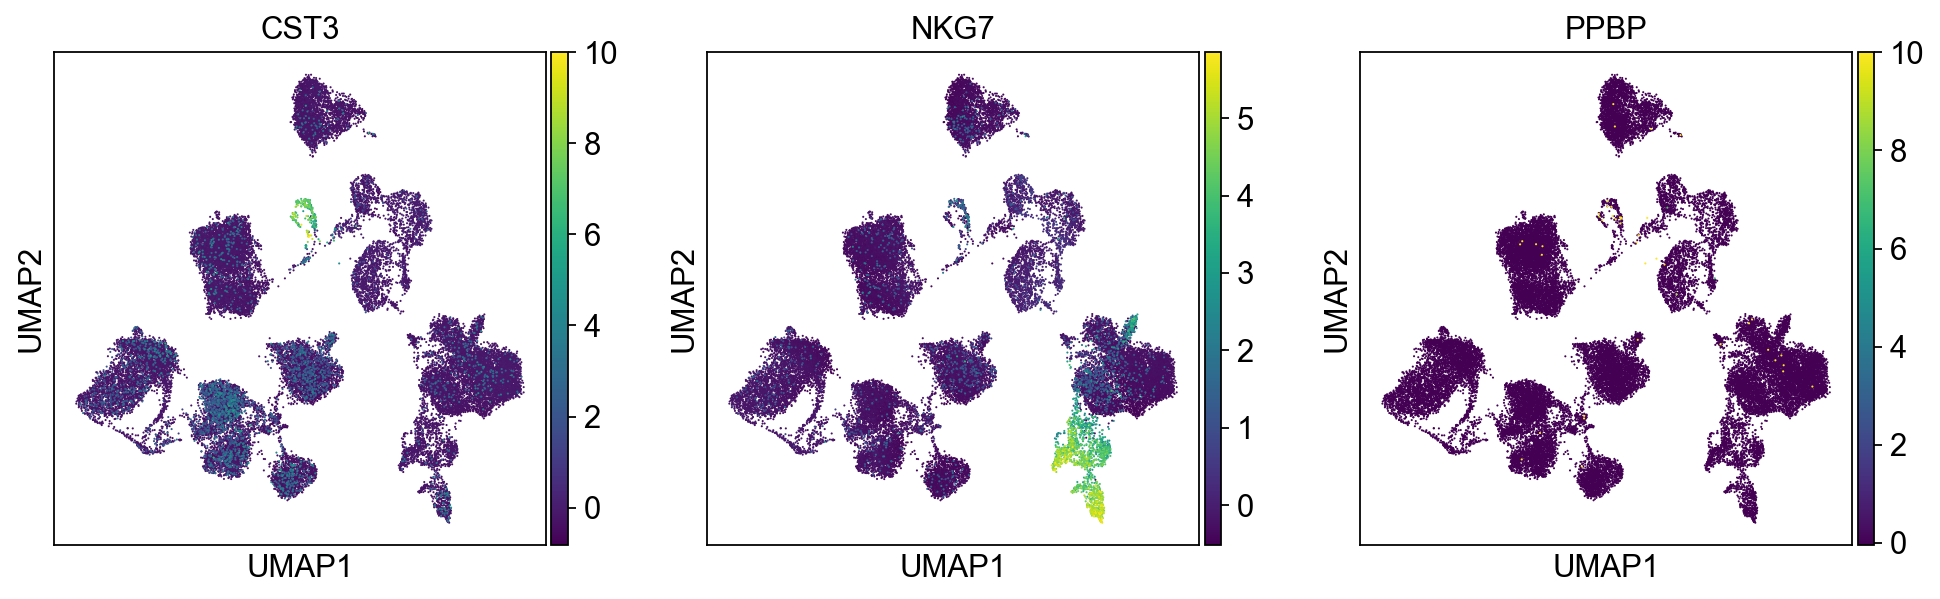

In [137]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


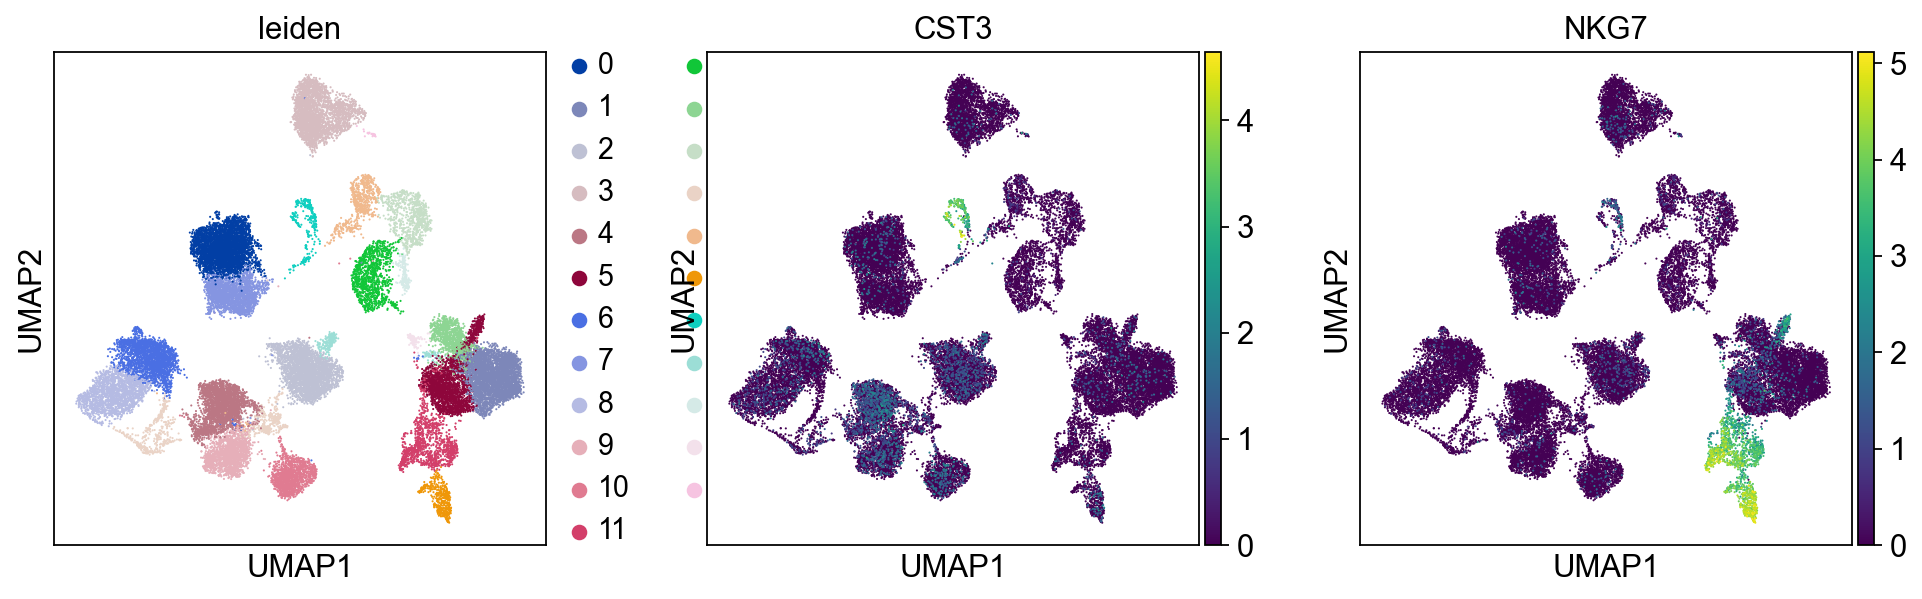

In [138]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
adata.write(results_file)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

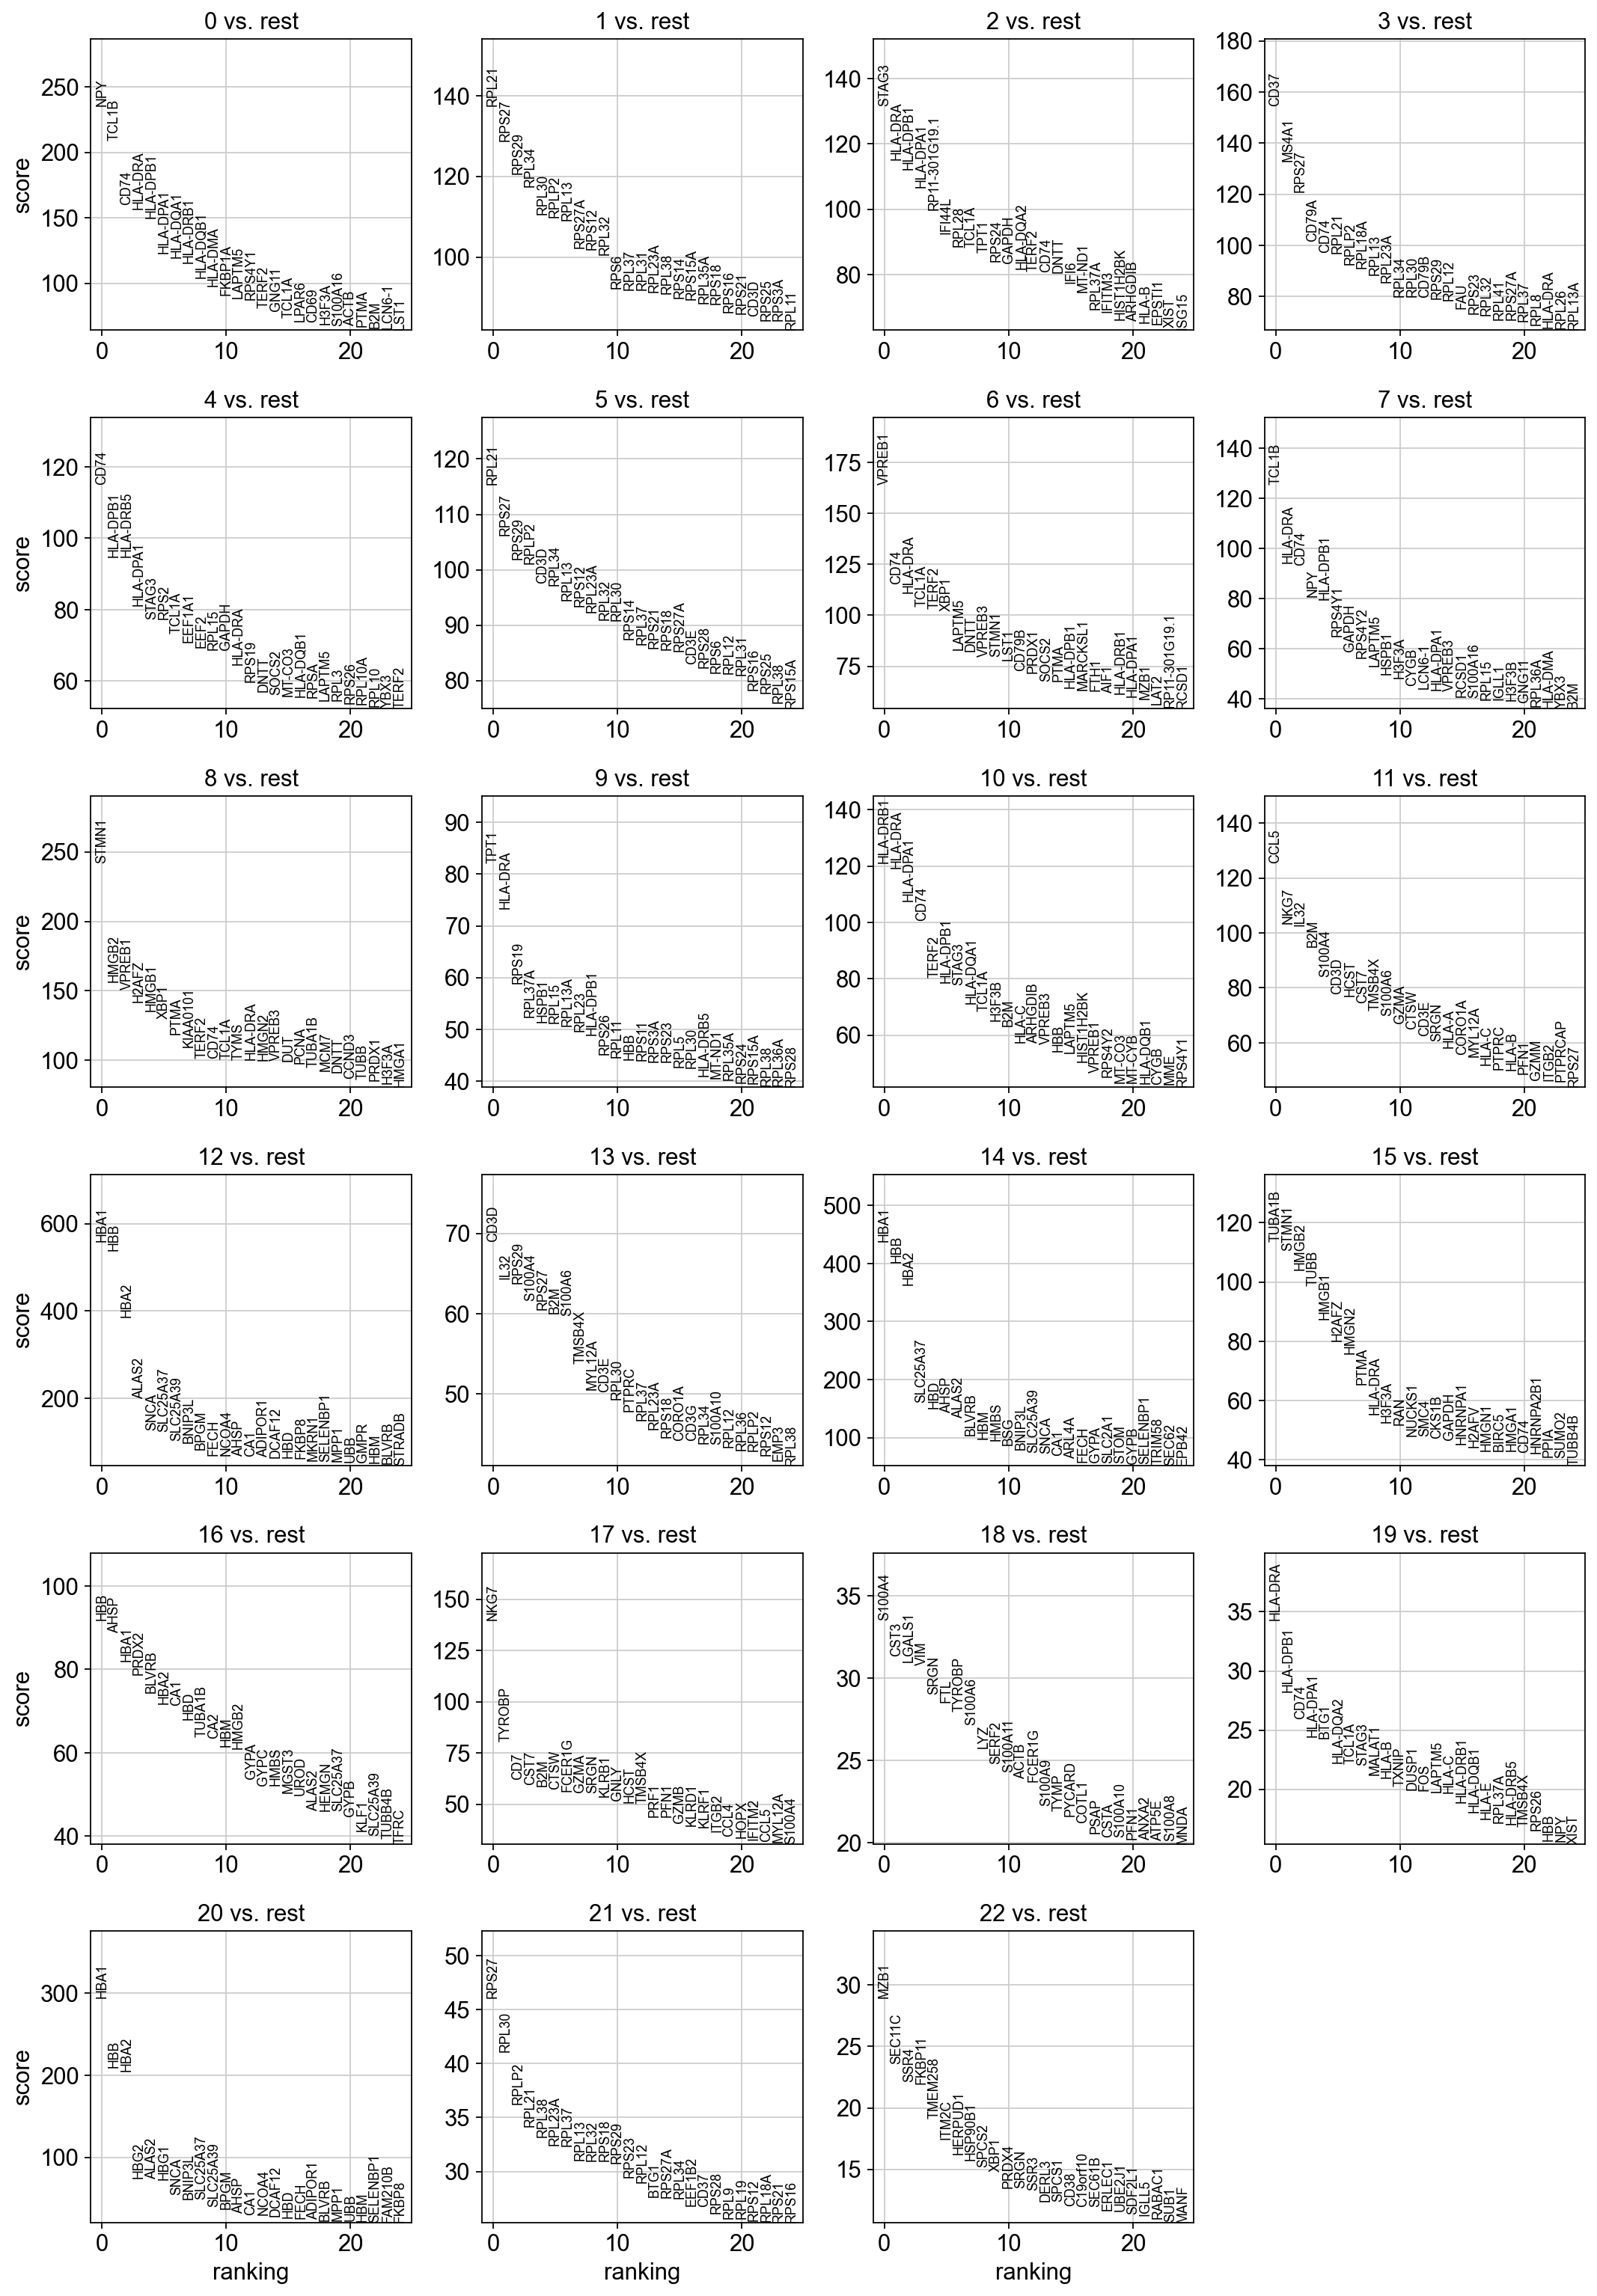

In [139]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [140]:
sc.settings.verbosity = 2  # reduce the verbosity
adata.write(results_file)


ranking genes
    finished (0:02:38)


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

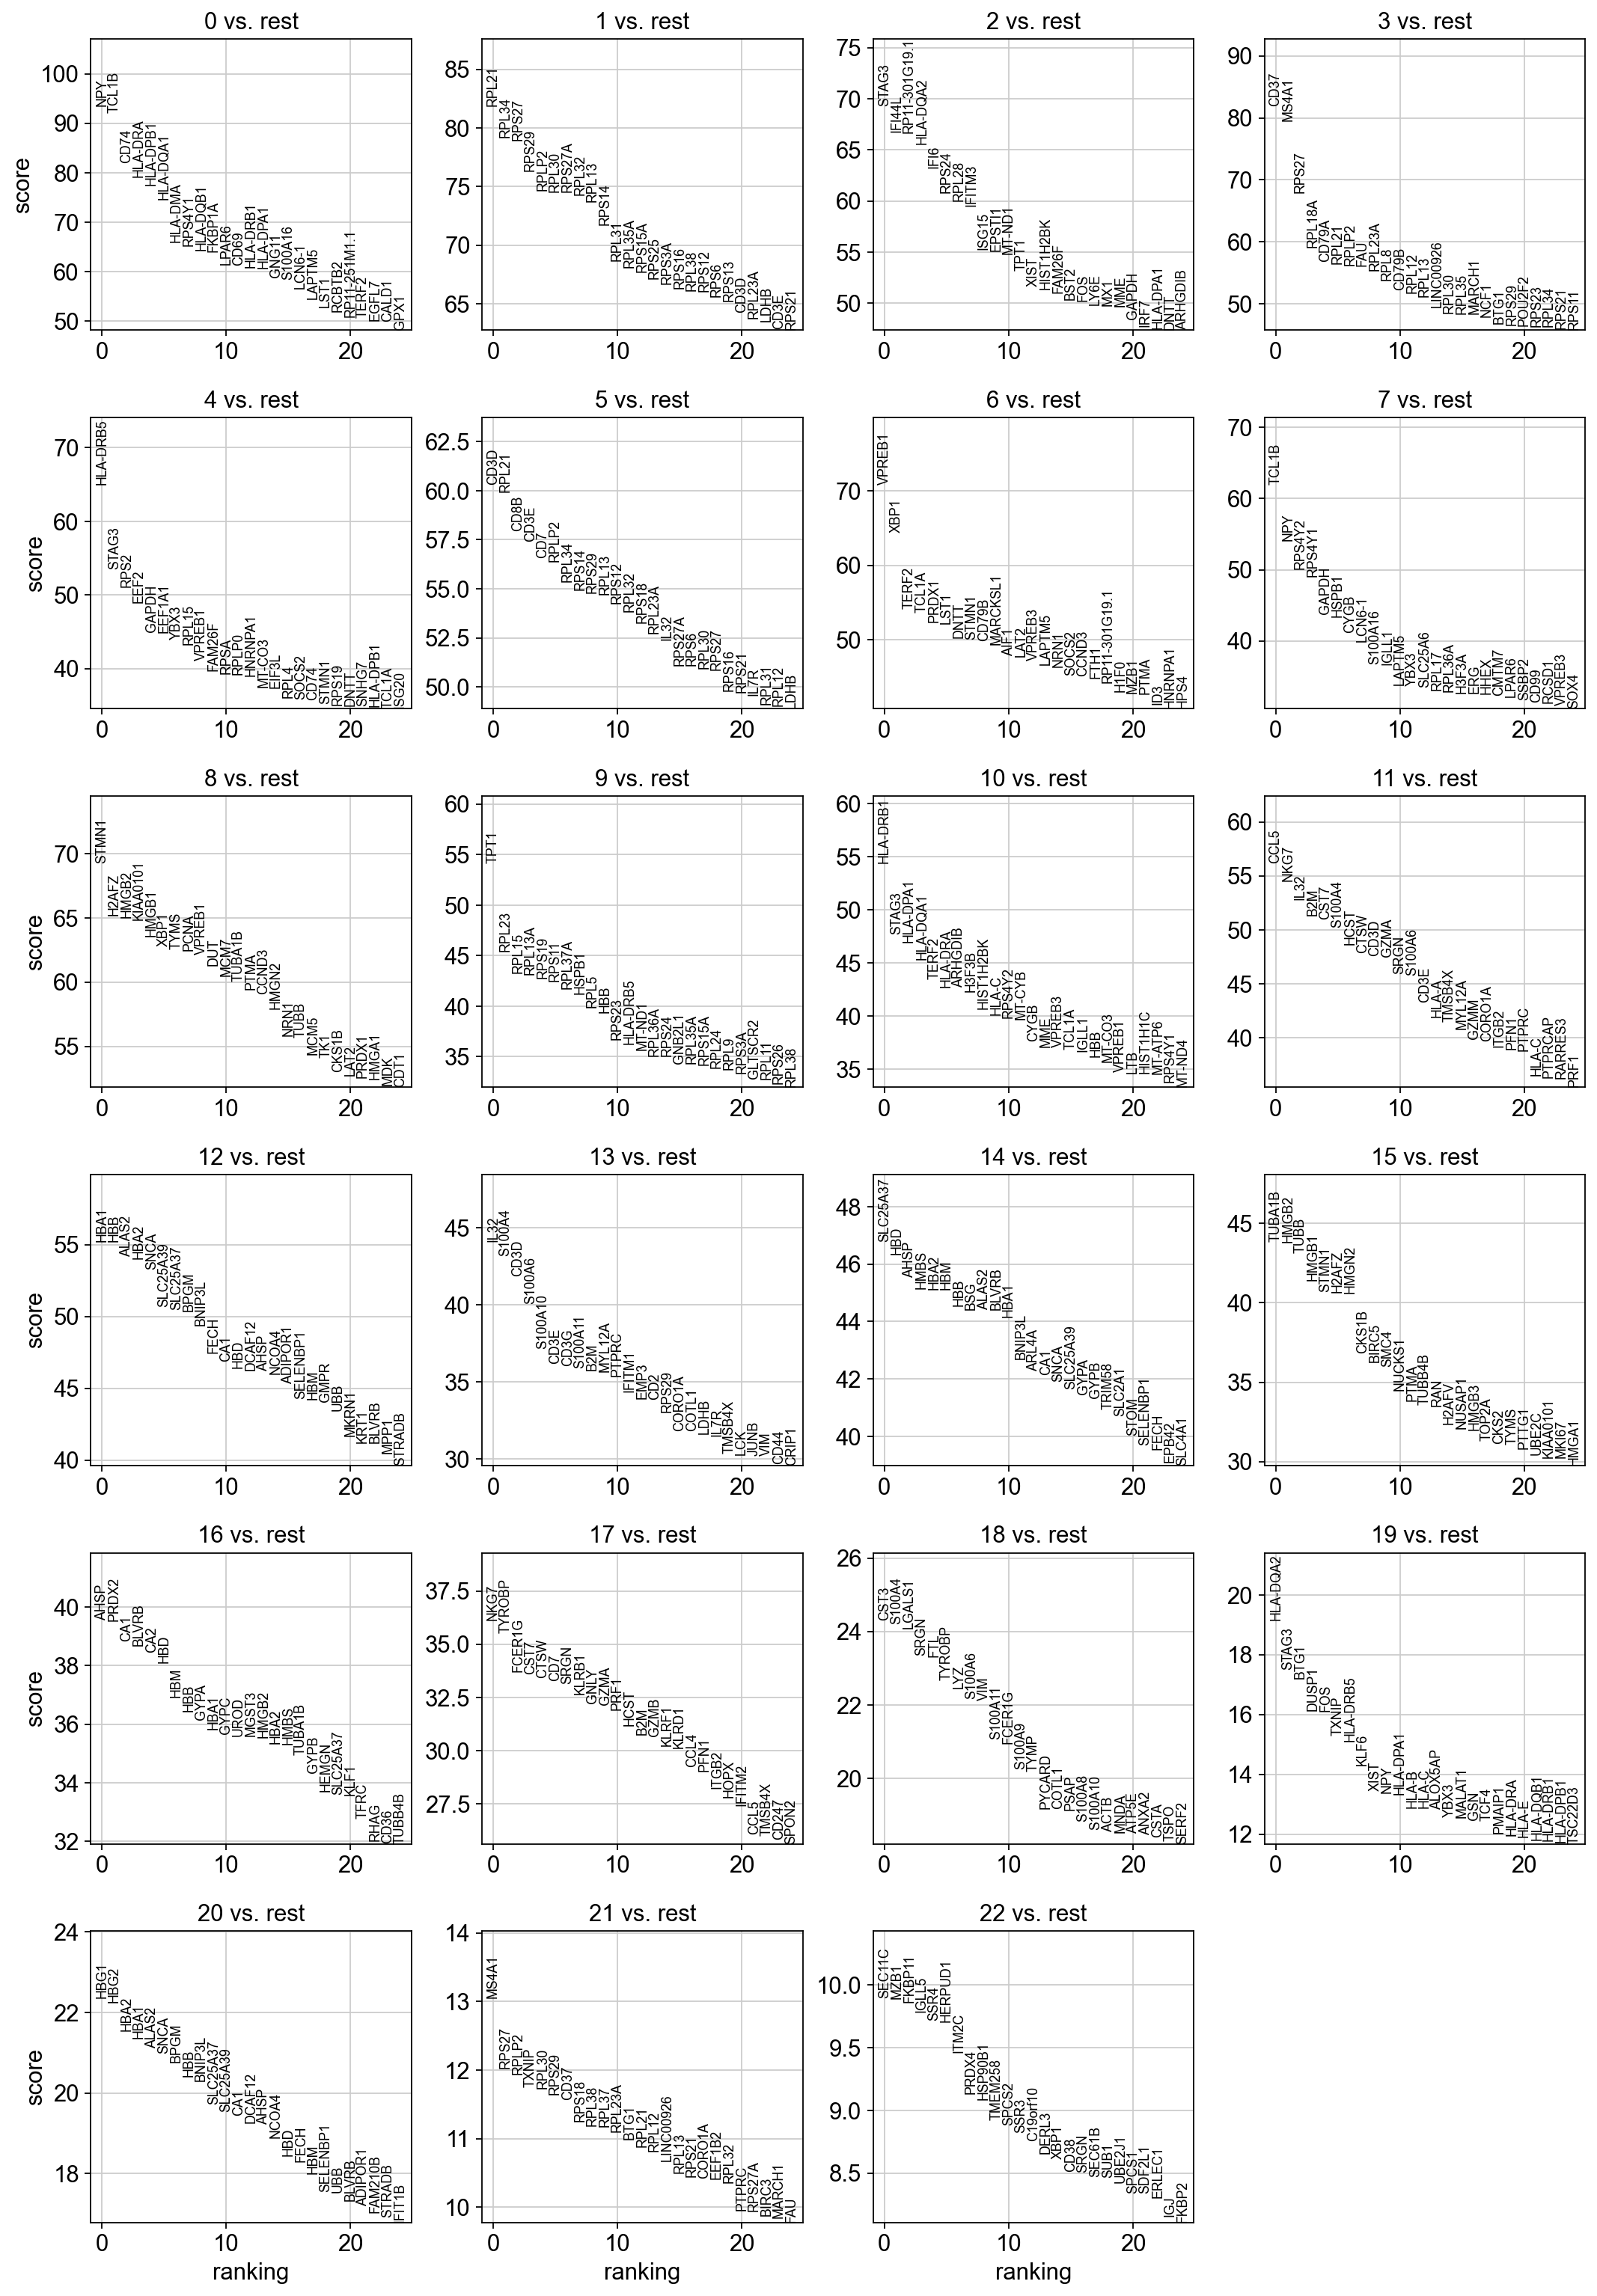

In [141]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


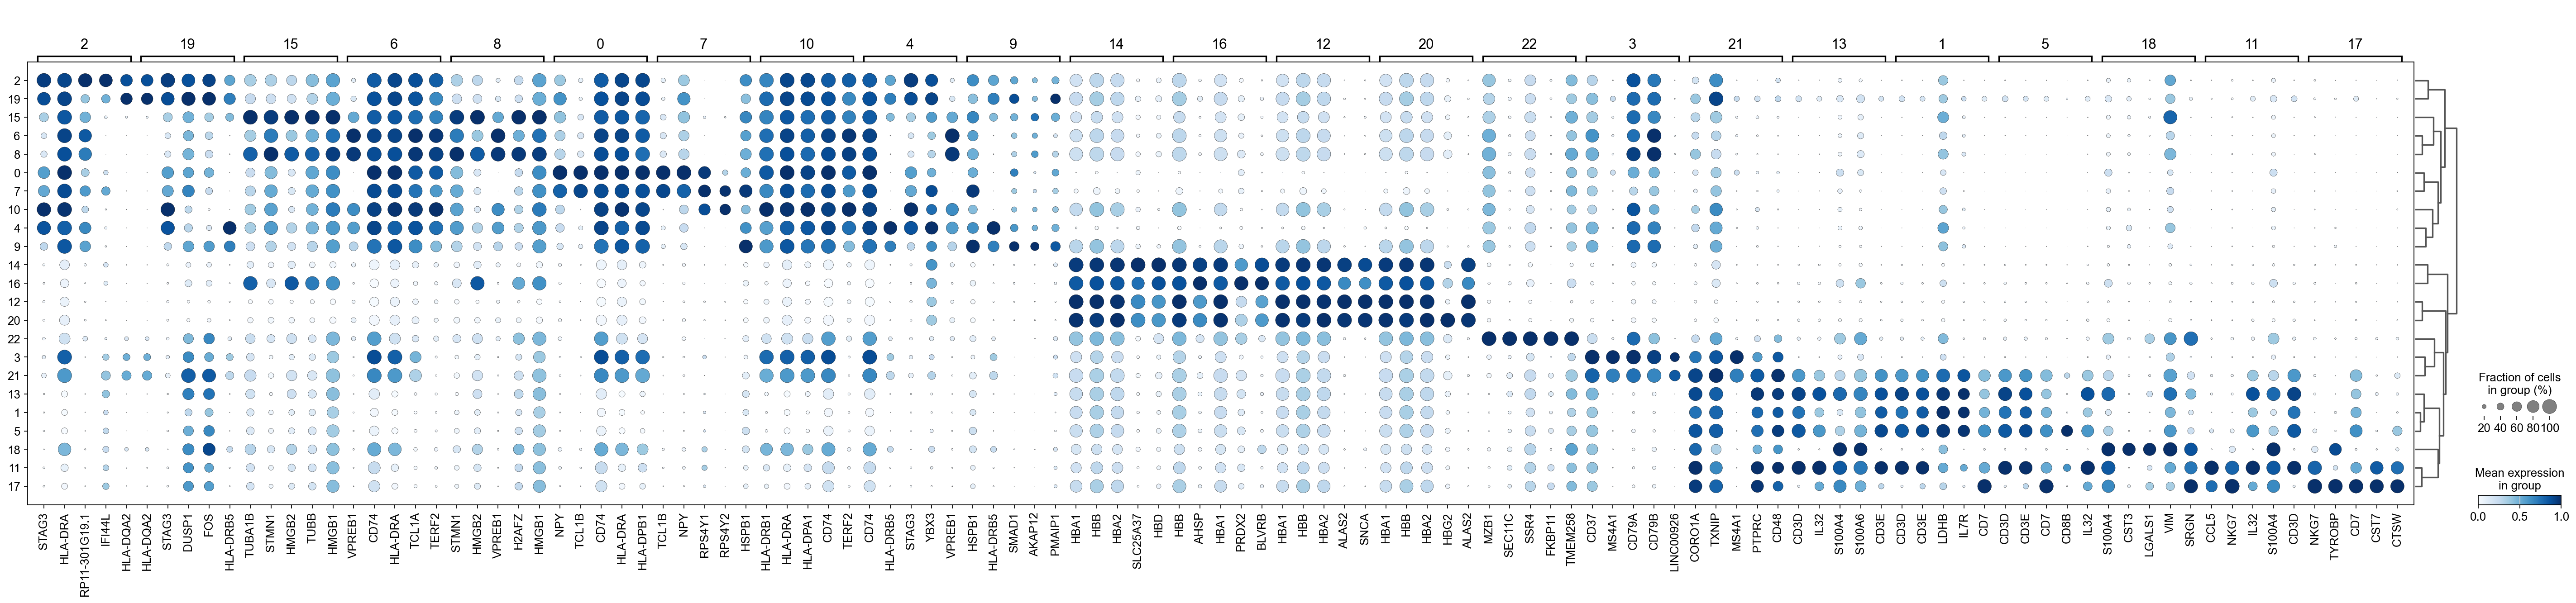

In [154]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, standard_scale = "var", color_map = "Blues", min_logfoldchange=2)

In [142]:
adata = sc.read(results_file)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


0      1              2      3         4      5        6         7  \
0       NPY  RPL21          STAG3   CD37      CD74  RPL21   VPREB1     TCL1B   
1     TCL1B  RPS27        HLA-DRA  MS4A1  HLA-DPB1  RPS27     CD74   HLA-DRA   
2      CD74  RPS29       HLA-DPB1  RPS27  HLA-DRB5  RPS29  HLA-DRA      CD74   
3   HLA-DRA  RPL34       HLA-DPA1  CD79A  HLA-DPA1  RPLP2    TCL1A       NPY   
4  HLA-DPB1  RPL30  RP11-301G19.1   CD74     STAG3   CD3D    TERF2  HLA-DPB1   

        8        9  ...      13        14      15     16      17      18  \
0   STMN1     TPT1  ...    CD3D      HBA1  TUBA1B    HBB    NKG7  S100A4   
1   HMGB2  HLA-DRA  ...    IL32       HBB   STMN1   AHSP  TYROBP    CST3   
2  VPREB1    RPS19  ...   RPS29      HBA2   HMGB2   HBA1     CD7  LGALS1   
3   H2AFZ   RPL37A  ...  S100A4  SLC25A37    TUBB  PRDX2    CST7     VIM   
4   HMGB1    HSPB1  ...   RPS27       HBD   HMGB1  BLVRB     B2M    SRGN   

         19     20     21       22  
0   HLA-DRA   HBA1  RPS27     MZB1  
1  HLA-DPB1    HBB  RPL30   SEC11C  
2      CD74   HBA2  RPLP2     SSR4  
3  HLA-DPA1   HBG2  RPL21   FKBP11  
4      BTG1  ALAS2  RPL38  TMEM258  

[5 rows x 23 columns]

In [143]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

0_n         0_s    1_n         1_s            2_n         2_s    3_n  \
0       NPY  235.362350  RPL21  137.401505          STAG3  131.552292   CD37   
1     TCL1B  209.157150  RPS27  128.750168        HLA-DRA  114.979881  MS4A1   
2      CD74  159.996597  RPS29  120.611046       HLA-DPB1  112.104996  RPS27   
3   HLA-DRA  156.424118  RPL34  117.487183       HLA-DPA1  106.520363  CD79A   
4  HLA-DPB1  149.486908  RPL30  110.616776  RP11-301G19.1   99.683624   CD74   

          3_s       4_n         4_s  ...    18_n       18_s      19_n  \
0  154.422165      CD74  115.035248  ...  S100A4  33.529163   HLA-DRA   
1  132.831924  HLA-DPB1   94.763649  ...    CST3  31.337627  HLA-DPB1   
2  120.946793  HLA-DRB5   94.751793  ...  LGALS1  30.972878      CD74   
3  101.604858  HLA-DPA1   80.991669  ...     VIM  30.771572  HLA-DPA1   
4   96.986717     STAG3   77.186943  ...    SRGN  29.017031      BTG1   

        19_s   20_n        20_s   21_n       21_s     22_n       22_s  
0  34.311119   HBA1  293.696991  RPS27  46.040569     MZB1  28.914127  
1  28.210691    HBB  209.681931  RPL30  41.073570   SEC11C  23.581820  
2  25.949049   HBA2  204.550171  RPLP2  36.243710     SSR4  22.095358  
3  24.431799   HBG2   74.782921  RPL21  34.162552   FKBP11  21.928301  
4  24.282452  ALAS2   73.155083  RPL38  33.140011  TMEM258  19.117241  

[5 rows x 46 columns]

ranking genes
    finished (0:00:15)


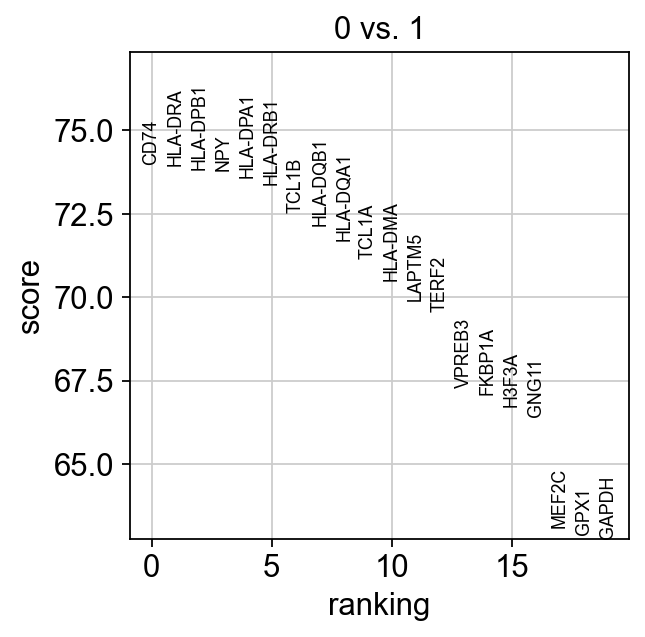

In [144]:
adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


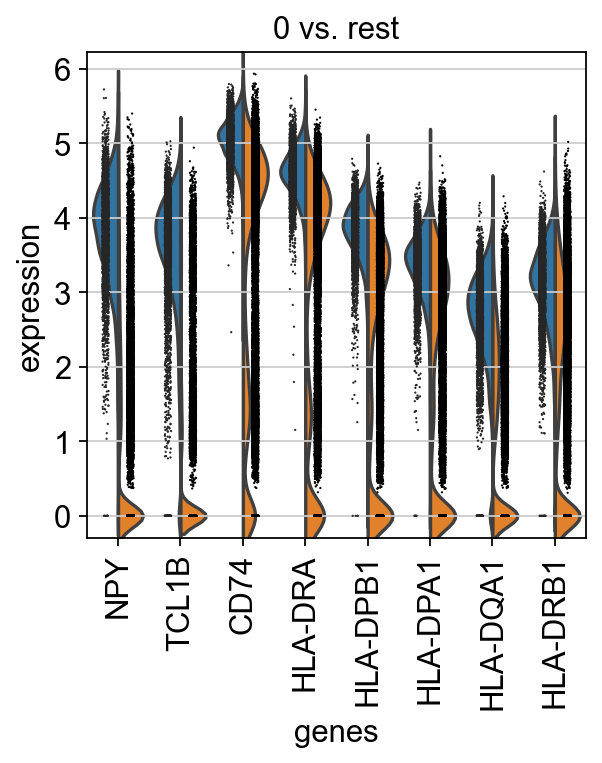

In [145]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

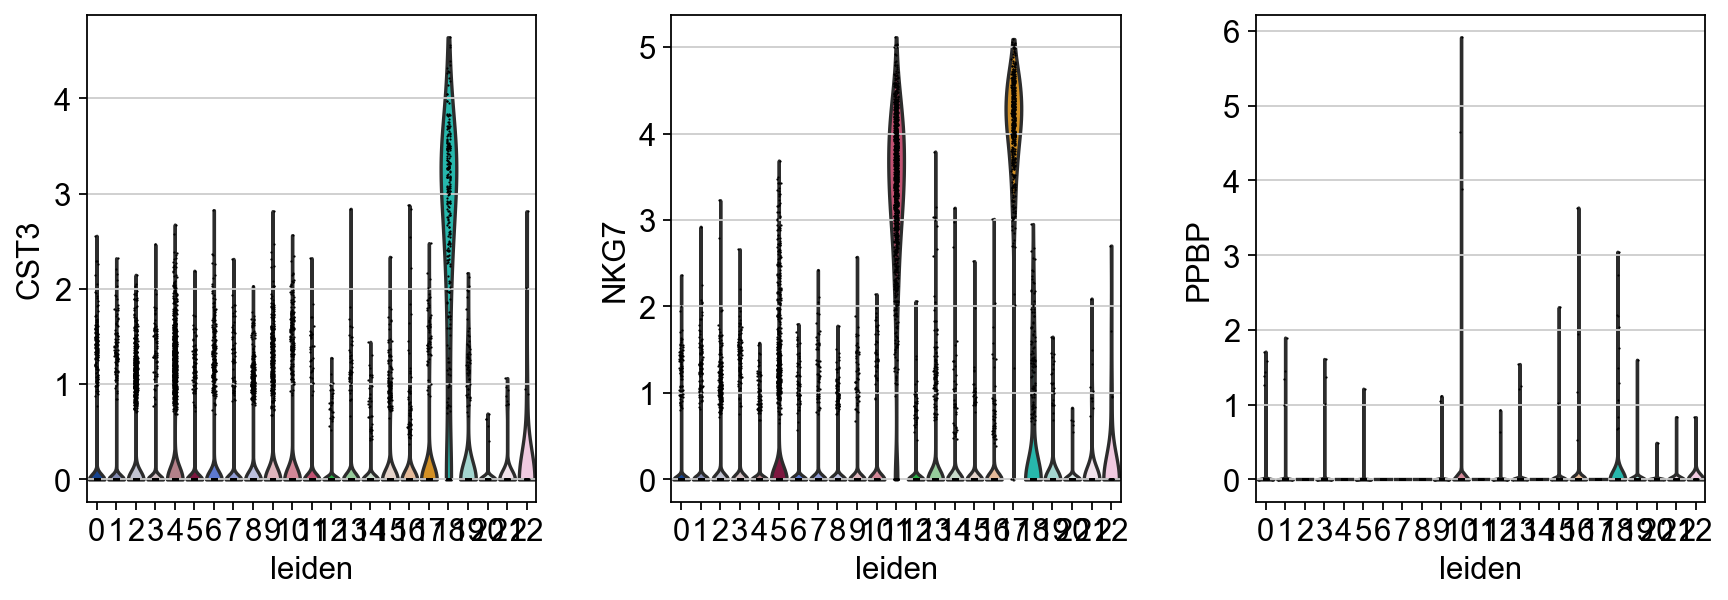

In [146]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')


/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


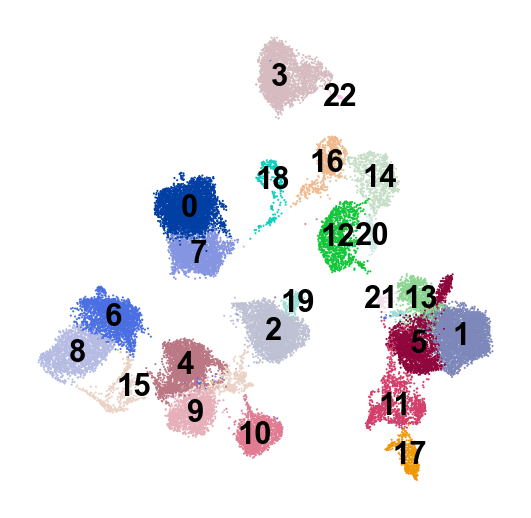

In [147]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [150]:
#sc.pl.dotplot(adata, marker_genes, groupby='leiden');
#sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")
sc.pl.rank_genes_groups_dotplot()


#sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")


TypeError: rank_genes_groups_dotplot() missing 1 required positional argument: 'adata'

In [ ]:
adata
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')
